# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
The is the problem introduction:

Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1)$ and $a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Problem formulation

### Discription:

![Project_1](img/Project_1.png)

This is a 2-D problem. At the beginning, the rocket has a initial location (x, y) and initial velocity (x_dot, y_dot). The nozzle of the rocket can rotate to change the direction of thrust. The angle between the thrust direction and y-axis is alpha. The ratio of the thrust can also change.

### Assumptions: 
The rocket is considered as a mass dot. Therefore, the rotation movement of the rocket is not considered.

### Variables:
s: state

x: x coordinate

x_dot: velocity in x direction

y: y coordinate 

y_dot: velocity in y direction

A: the ratio of the thrust, range from 0 to 1.  

alpha: the angle between the thrust direction and y-axis. 


### Objective function:

$$
\begin{aligned}
\min_{\theta} \quad & ||s(T)||^2 
\end{aligned}
$$

### Constraints:

$$
\begin{aligned}
\quad & x(t+1) = x(t) + v_x(t) \Delta t, \\
\quad & y(t+1) = x(t) + v_y(t) \Delta t, \\
\quad & v_x(t+1) = v_x(t) + a_x(t) \Delta t, \\
\quad & v_y(t+1) = v_y(t) + a_y(t) \Delta t, \\
\quad & a_x(t), a_y(t) = f_{\theta}(s(t)), ~\forall t=1,...,T-1 
\end{aligned}
$$

---

## 3. Code

In [95]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 10.0  # m/s2, gravity constant
BOOST_ACCEL = 15.0  # m/s2, thrust constant

# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity       
        delta_state_gravity = -t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])

        # Thrust
        hori = action[1]*2.0-1.0
        delta_state = BOOST_ACCEL * FRAME_TIME * (t.tensor([0., 1.0 , 0., 0.]) * action[0]+t.tensor([0., 0. , 0., 1.0]) * hori)

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),#
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [20.0, 0., 10.0, 0.]  
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        y1 = data[:, 0]
        y2 = data[:, 1]
        x1 = data[:, 2]
        x2 = data[:, 3]
        tt = range(20)
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        ac = data1[:, 0]
        an = data1[:, 1]
        plt.plot(x1, y1)
        plt.show()
        #plt.plot(x2, y2)
        #plt.show()
        #plt.plot(tt, ac)
        #plt.show()
        #plt.plot(tt, an)
        #plt.show()


[1] loss: 6095.064


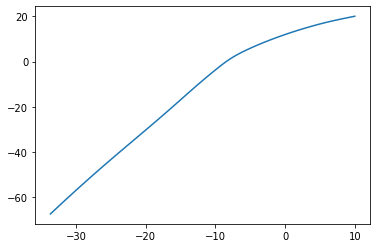

[2] loss: 2030.730


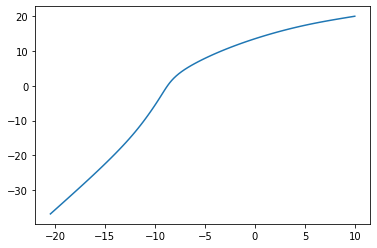

[3] loss: 864.865


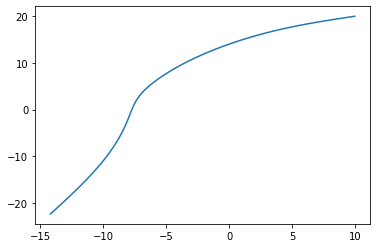

[4] loss: 449.381


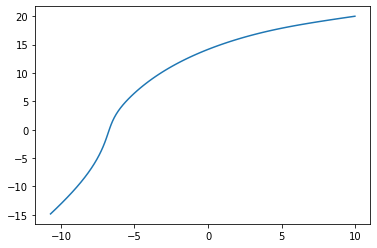

[5] loss: 263.112


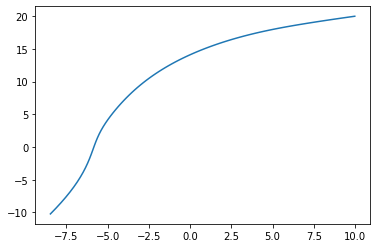

[6] loss: 167.152


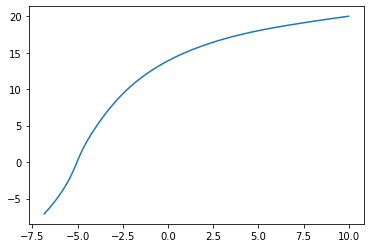

[7] loss: 112.555


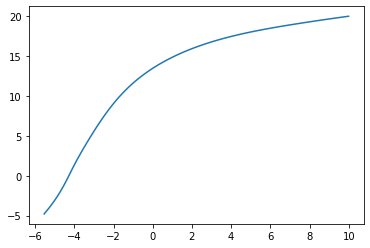

[8] loss: 81.551


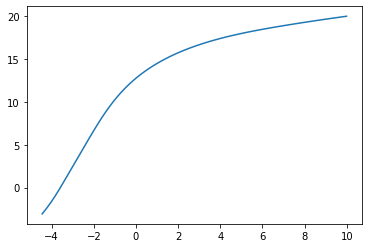

[9] loss: 64.166


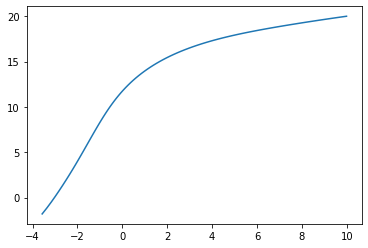

[10] loss: 53.785


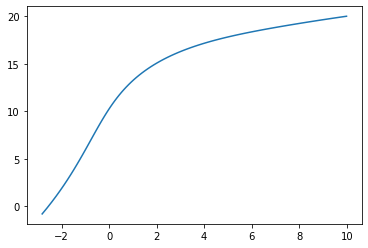

[11] loss: 47.223


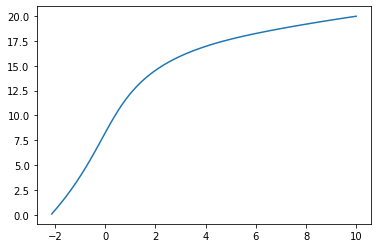

[12] loss: 43.921


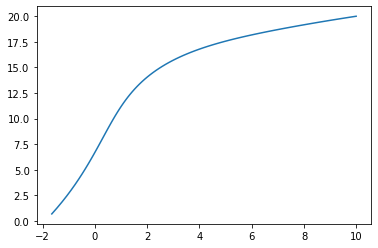

[13] loss: 42.294


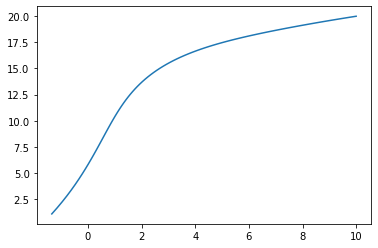

[14] loss: 41.356


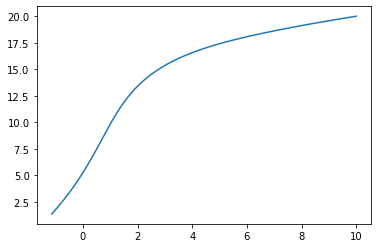

[15] loss: 40.672


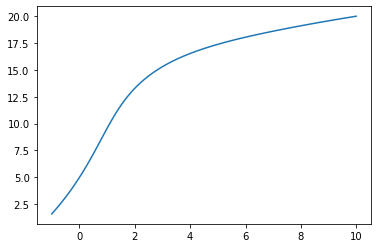

[16] loss: 39.901


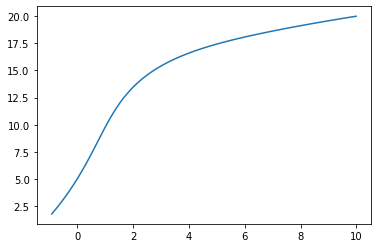

[17] loss: 38.635


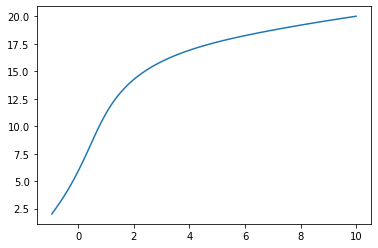

[18] loss: 37.276


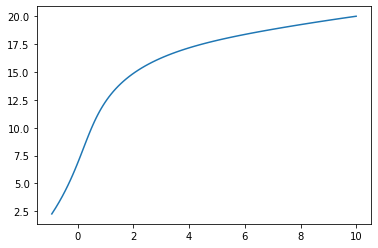

[19] loss: 35.589


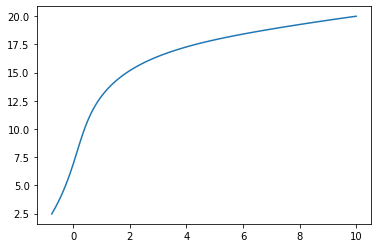

[20] loss: 29.175


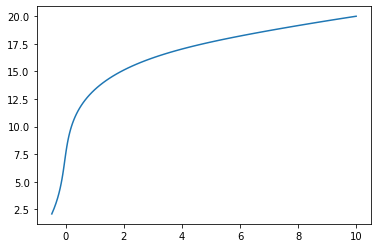

[21] loss: 23.681


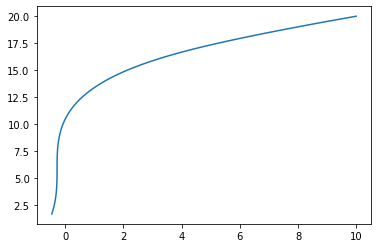

[22] loss: 14.108


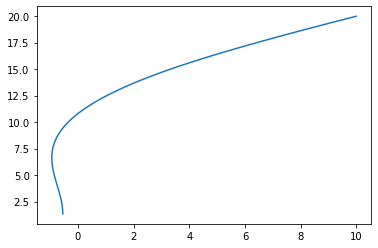

[23] loss: 8.391


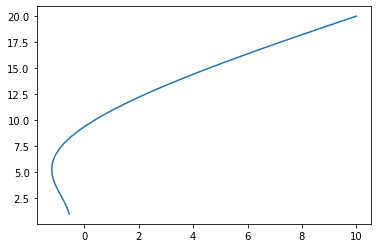

[24] loss: 5.647


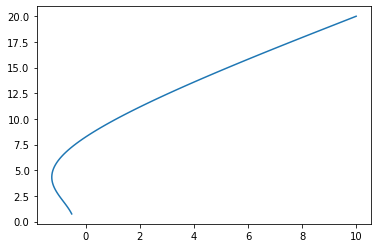

[25] loss: 4.085


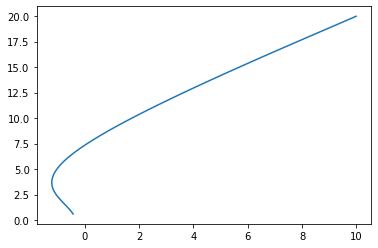

[26] loss: 3.030


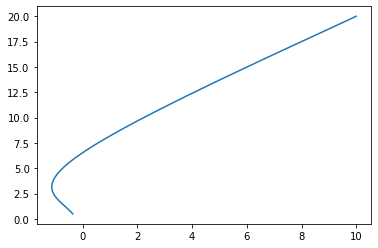

[27] loss: 2.311


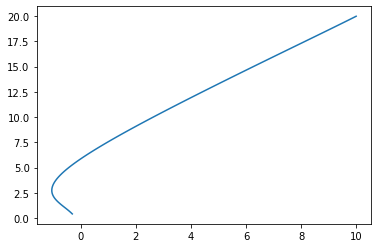

[28] loss: 1.794


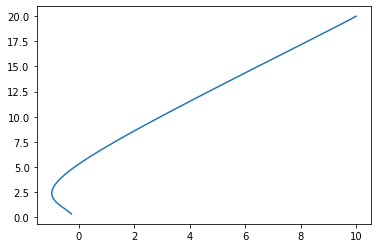

[29] loss: 1.398


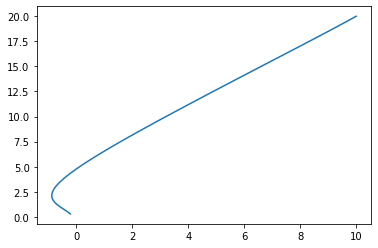

[30] loss: 1.082


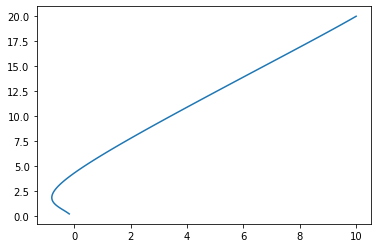

[31] loss: 0.825


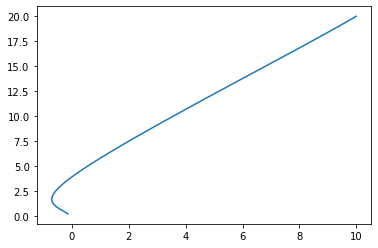

[32] loss: 0.619


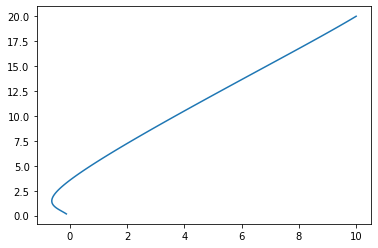

[33] loss: 0.457


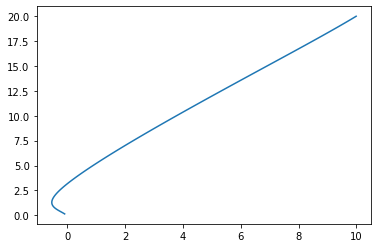

[34] loss: 0.332


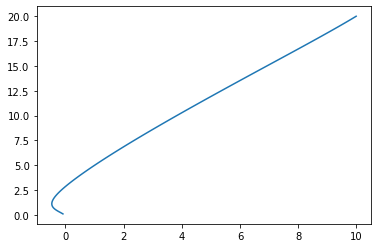

[35] loss: 0.235


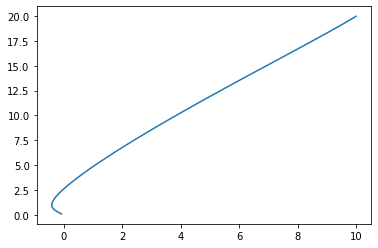

[36] loss: 0.166


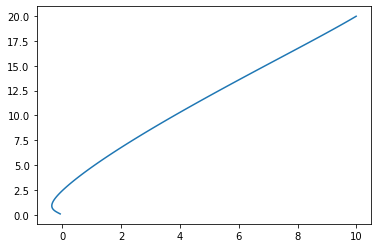

[37] loss: 0.117


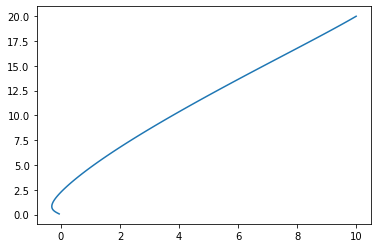

[38] loss: 0.082


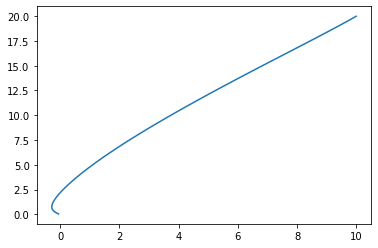

[39] loss: 0.057


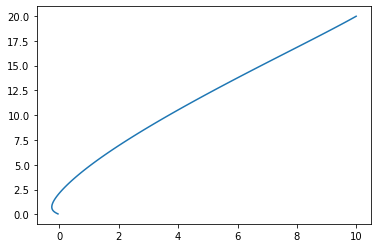

[40] loss: 0.039


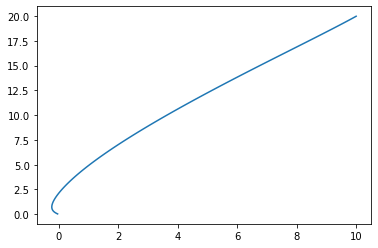

[41] loss: 0.027


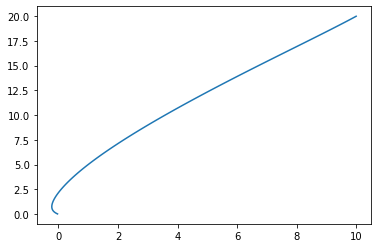

[42] loss: 0.018


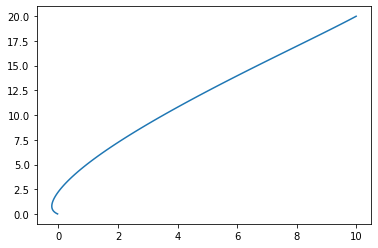

[43] loss: 0.012


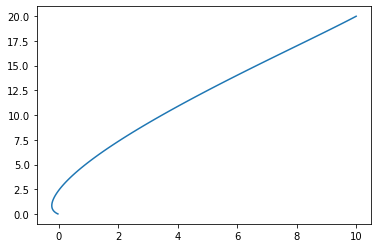

[44] loss: 0.008


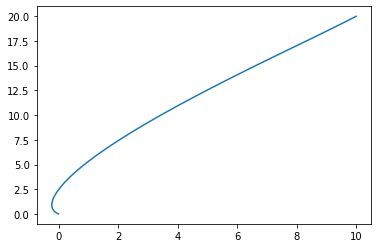

[45] loss: 0.005


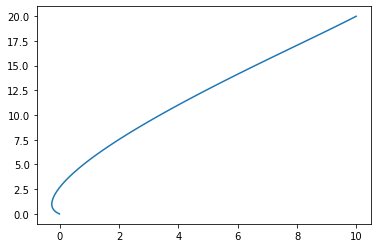

[46] loss: 0.003


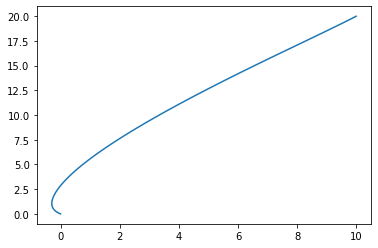

[47] loss: 0.002


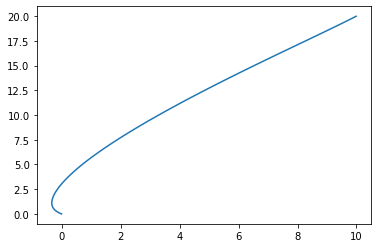

[48] loss: 0.001


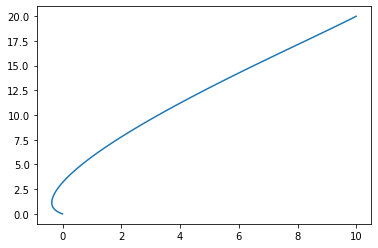

[49] loss: 0.001


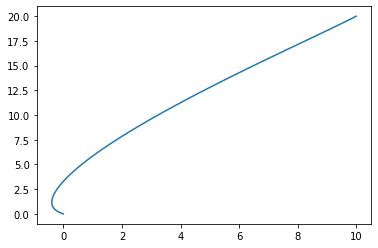

[50] loss: 0.001


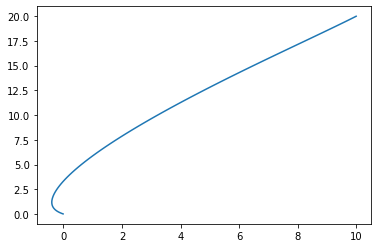

[51] loss: 0.000


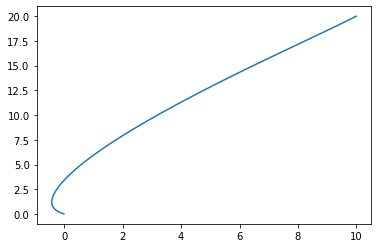

[52] loss: 0.000


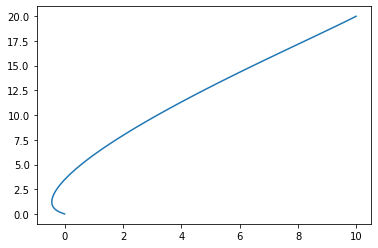

[53] loss: 0.000


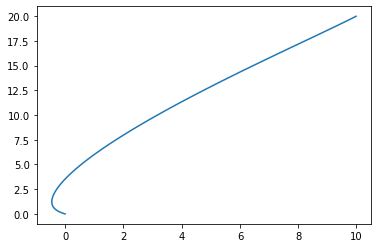

[54] loss: 0.000


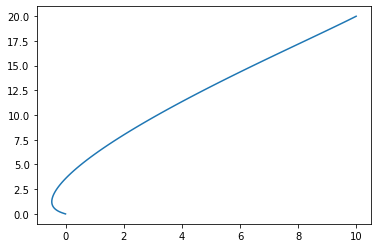

[55] loss: 0.000


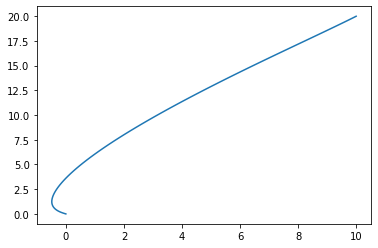

[56] loss: 0.000


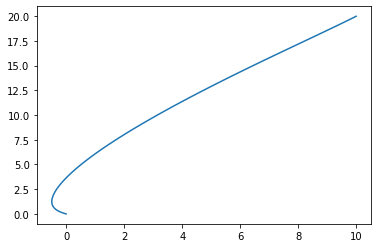

[57] loss: 0.000


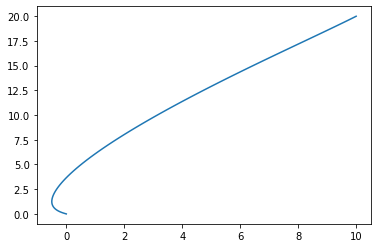

[58] loss: 0.000


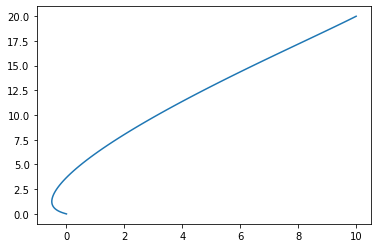

[59] loss: 0.000


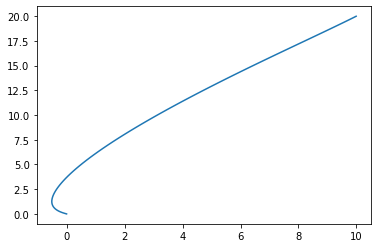

[60] loss: 0.000


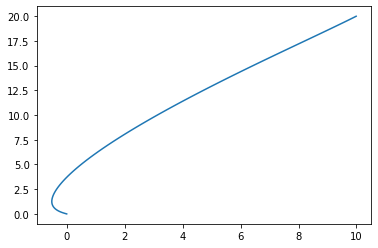

[61] loss: 0.000


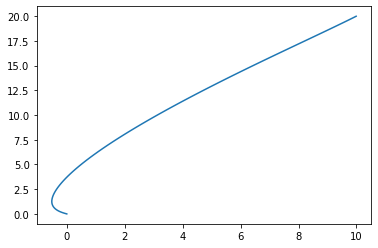

[62] loss: 0.000


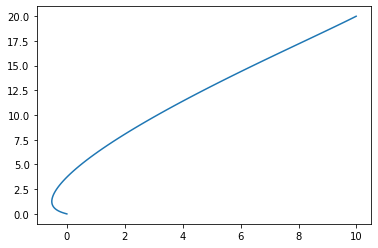

[63] loss: 0.000


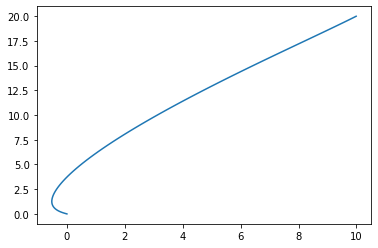

[64] loss: 0.000


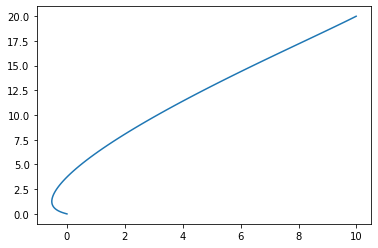

[65] loss: 0.000


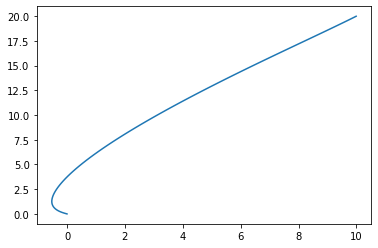

[66] loss: 0.000


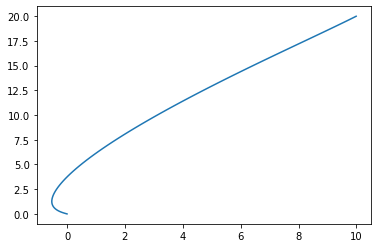

[67] loss: 0.000


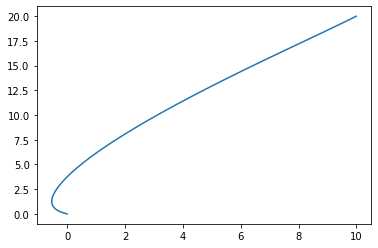

[68] loss: 0.000


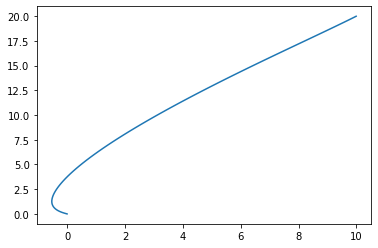

[69] loss: 0.000


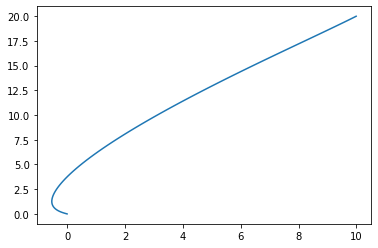

[70] loss: 0.000


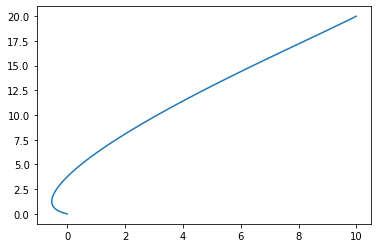

[71] loss: 0.000


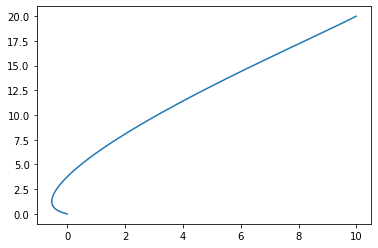

[72] loss: 0.000


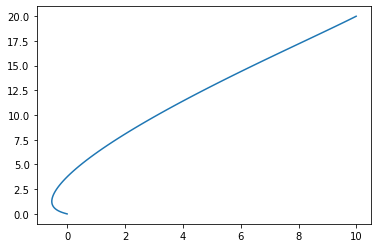

[73] loss: 0.000


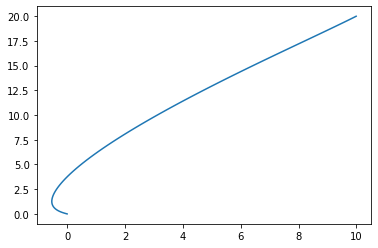

[74] loss: 0.000


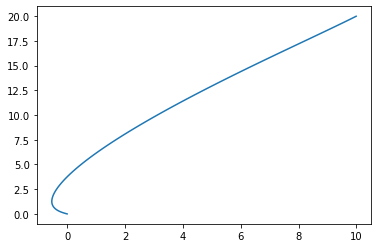

[75] loss: 0.000


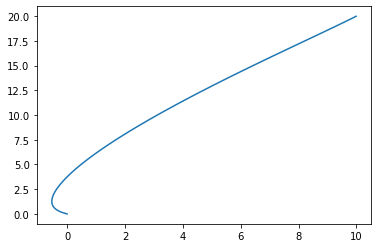

[76] loss: 0.000


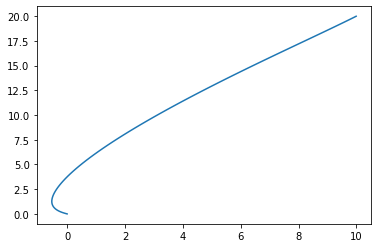

[77] loss: 0.000


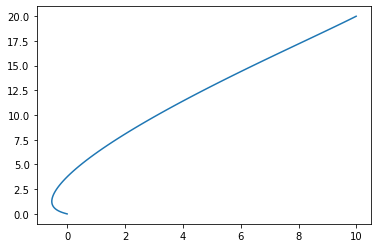

[78] loss: 0.000


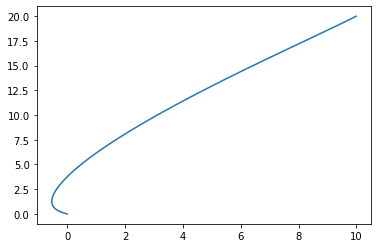

[79] loss: 0.000


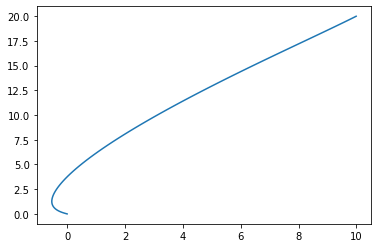

[80] loss: 0.000


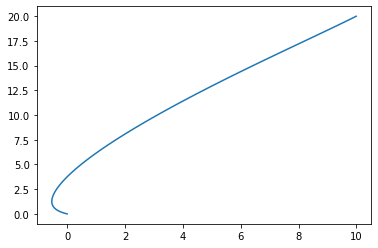

[81] loss: 0.000


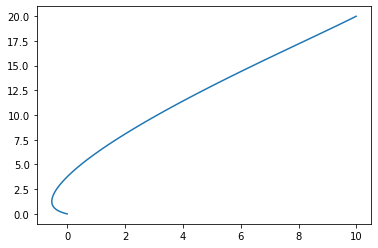

[82] loss: 0.000


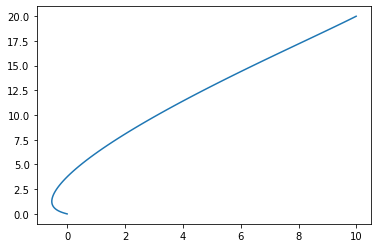

[83] loss: 0.000


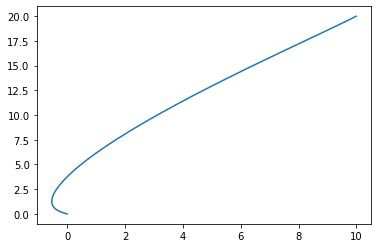

[84] loss: 0.000


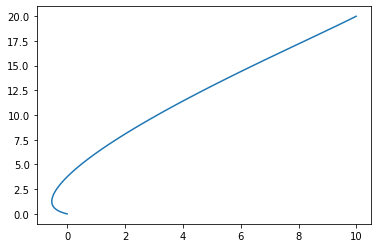

[85] loss: 0.000


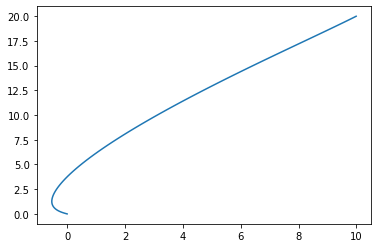

[86] loss: 0.000


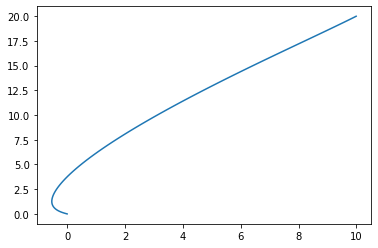

[87] loss: 0.000


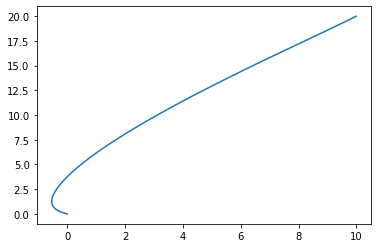

[88] loss: 0.000


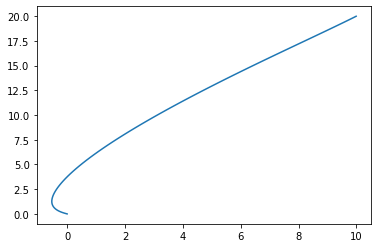

[89] loss: 0.000


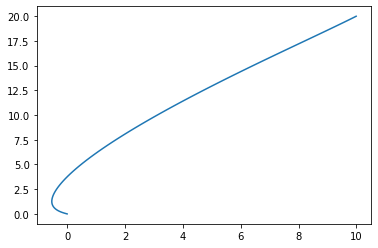

[90] loss: 0.000


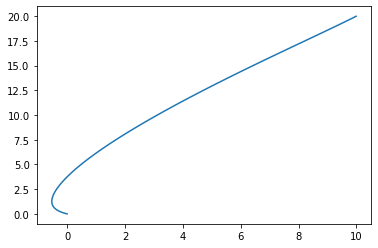

[91] loss: 0.000


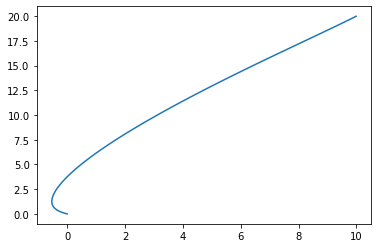

[92] loss: 0.000


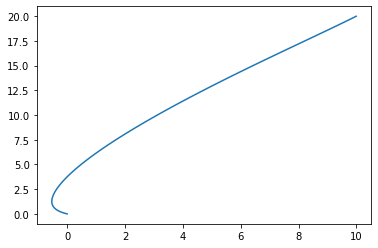

[93] loss: 0.000


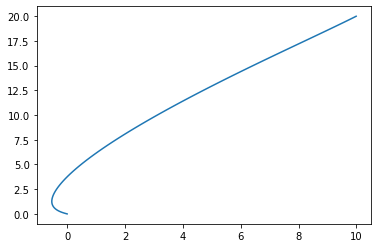

[94] loss: 0.000


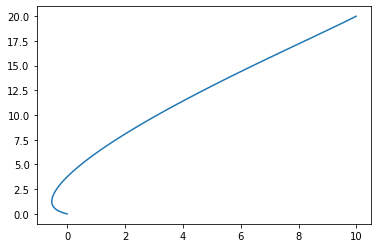

[95] loss: 0.000


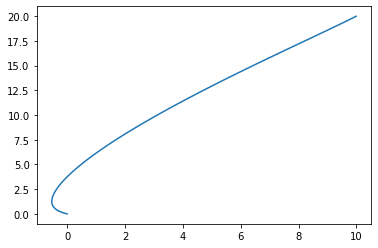

[96] loss: 0.000


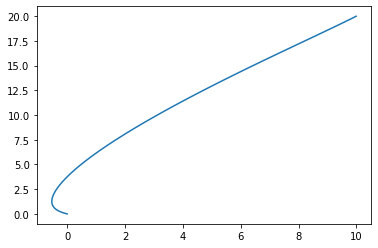

[97] loss: 0.000


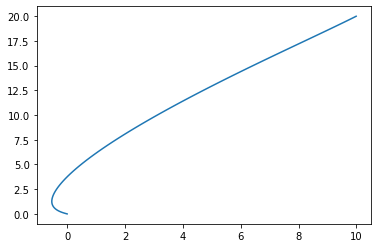

[98] loss: 0.000


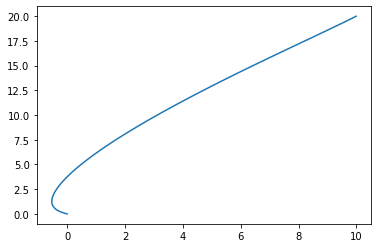

[99] loss: 0.000


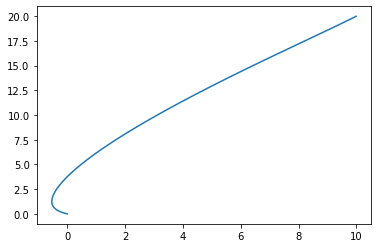

[100] loss: 0.000


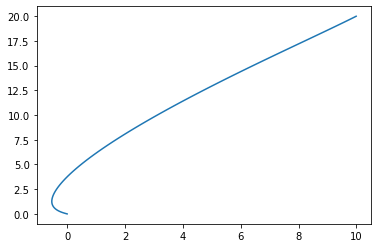

[101] loss: 0.000


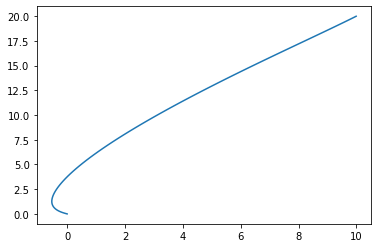

[102] loss: 0.000


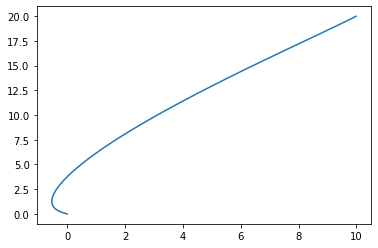

[103] loss: 0.000


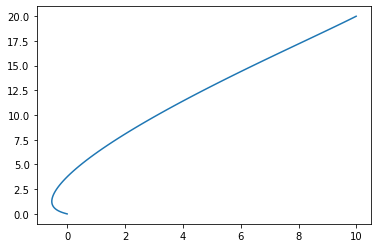

[104] loss: 0.000


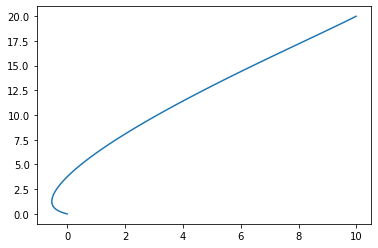

[105] loss: 0.000


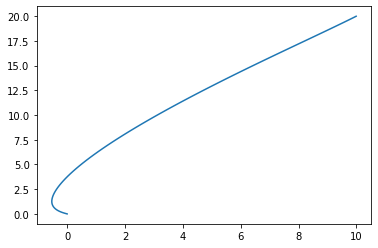

[106] loss: 0.000


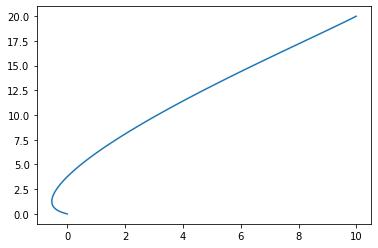

[107] loss: 0.000


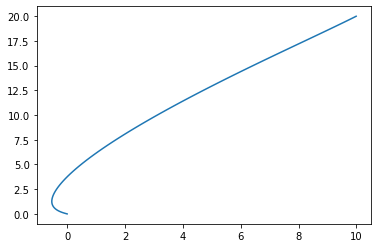

[108] loss: 0.000


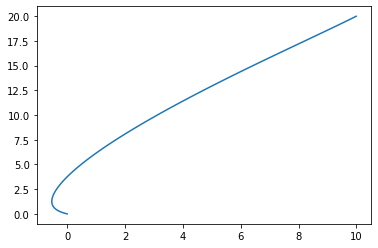

[109] loss: 0.000


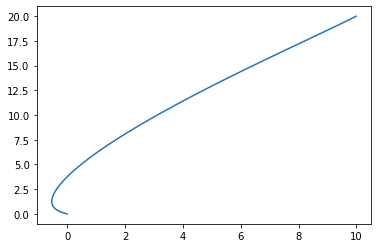

[110] loss: 0.000


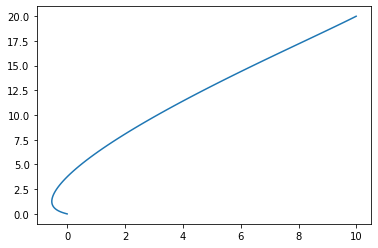

[111] loss: 0.000


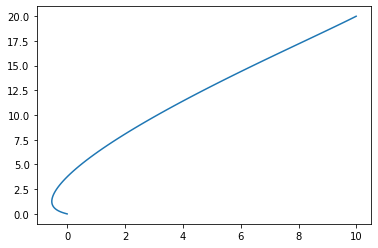

[112] loss: 0.000


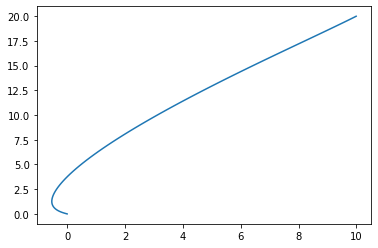

[113] loss: 0.000


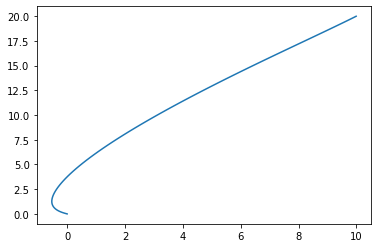

[114] loss: 0.000


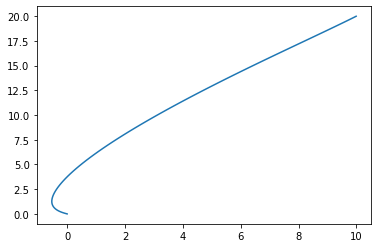

[115] loss: 0.000


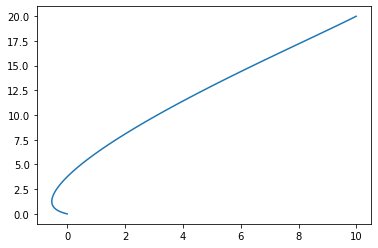

[116] loss: 0.000


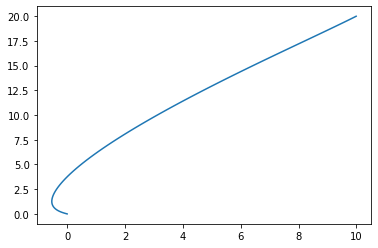

[117] loss: 0.000


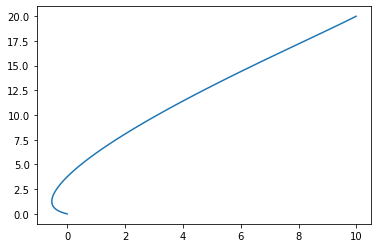

[118] loss: 0.000


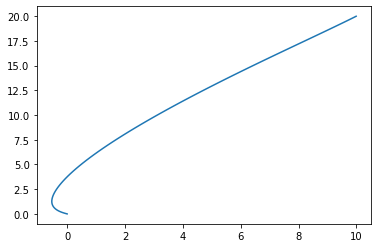

[119] loss: 0.000


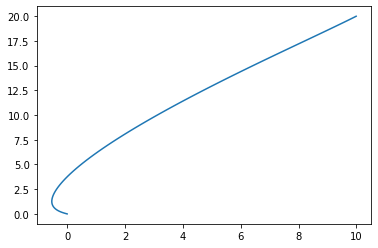

[120] loss: 0.000


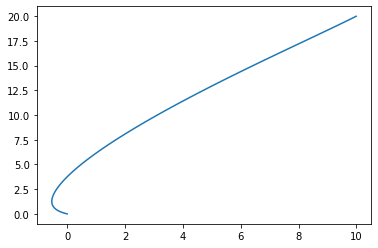

[121] loss: 0.000


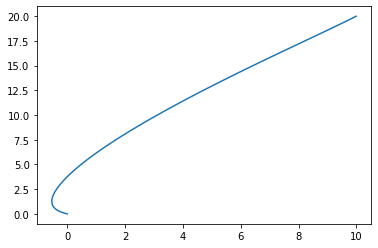

[122] loss: 0.000


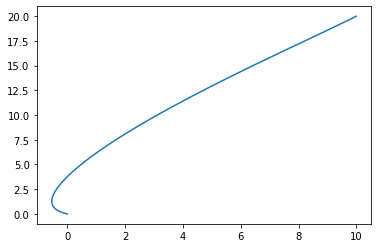

[123] loss: 0.000


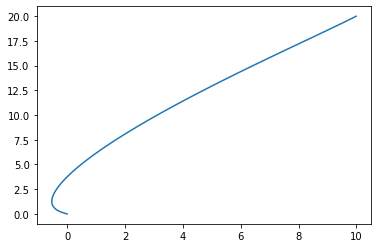

[124] loss: 0.000


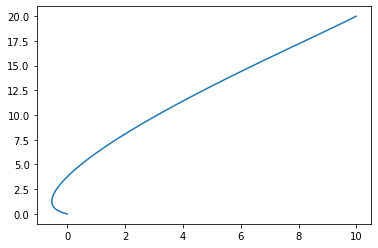

[125] loss: 0.000


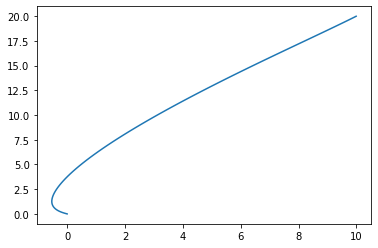

[126] loss: 0.000


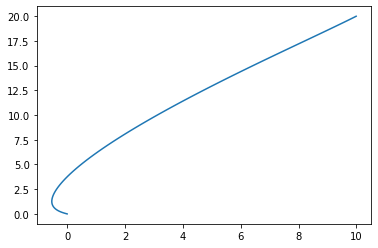

[127] loss: 0.000


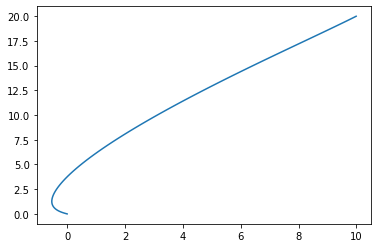

[128] loss: 0.000


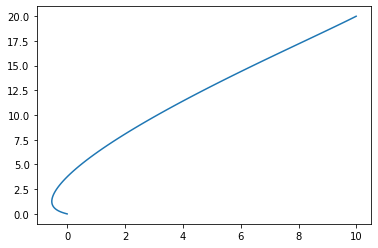

[129] loss: 0.000


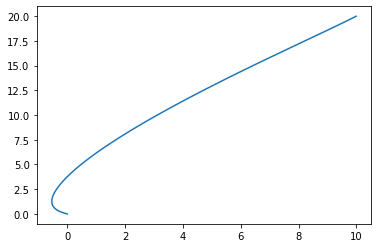

[130] loss: 0.000


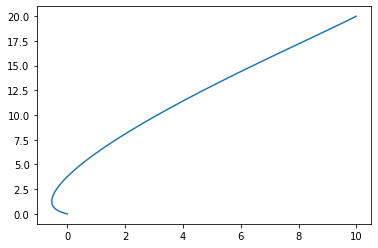

[131] loss: 0.000


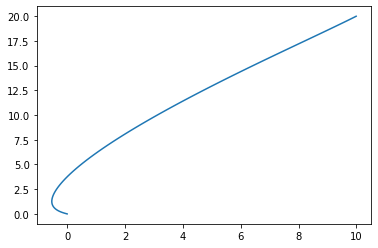

[132] loss: 0.000


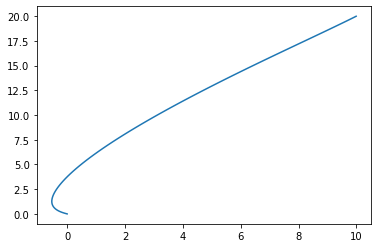

[133] loss: 0.000


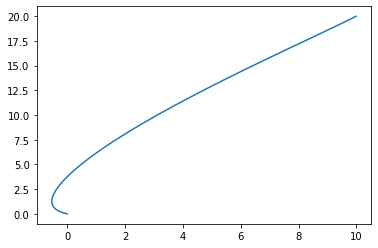

[134] loss: 0.000


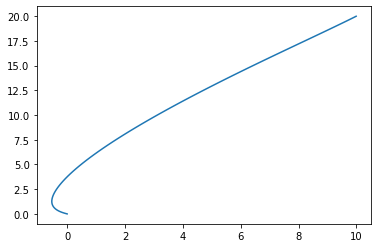

[135] loss: 0.000


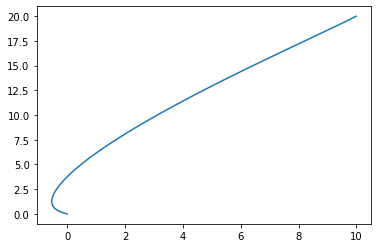

[136] loss: 0.000


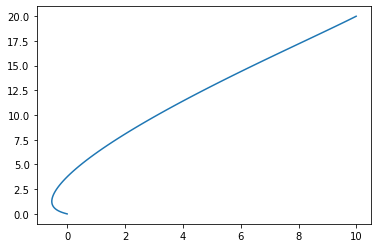

[137] loss: 0.000


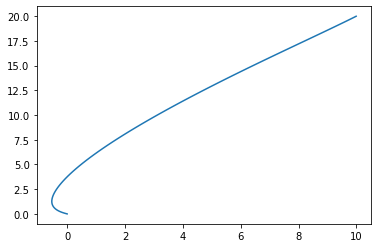

[138] loss: 0.000


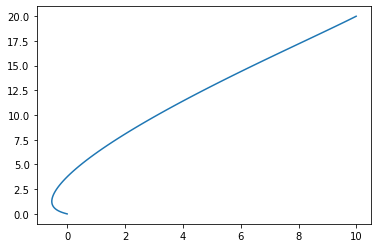

[139] loss: 0.000


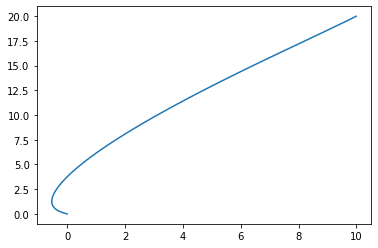

[140] loss: 0.000


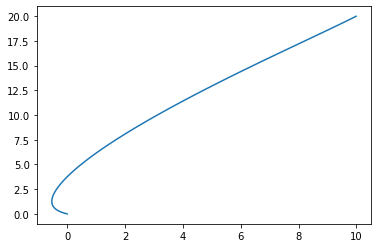

[141] loss: 0.000


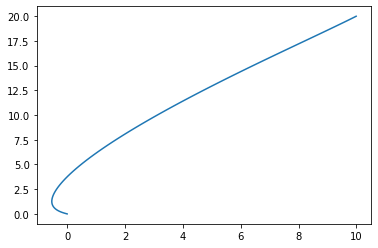

[142] loss: 0.000


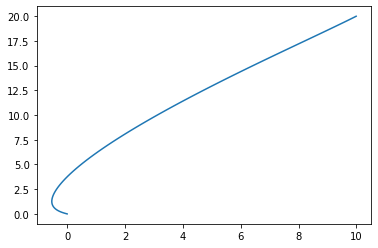

[143] loss: 0.000


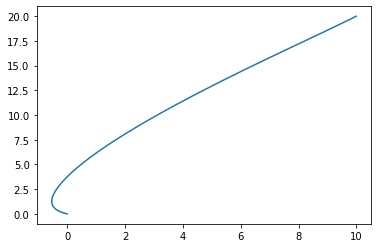

[144] loss: 0.000


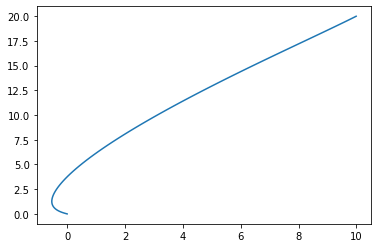

[145] loss: 0.000


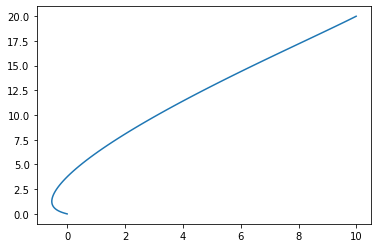

[146] loss: 0.000


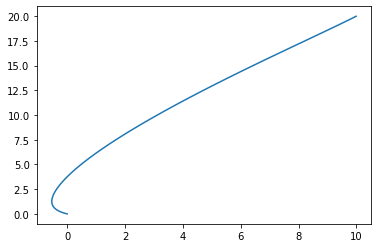

[147] loss: 0.000


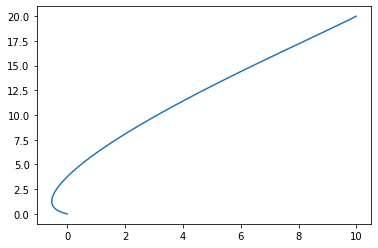

[148] loss: 0.000


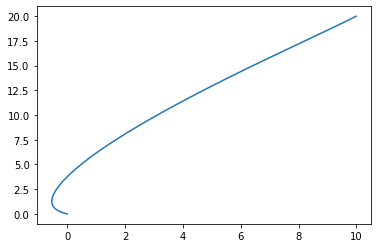

[149] loss: 0.000


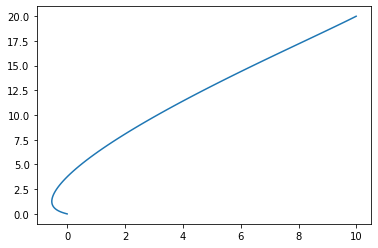

[150] loss: 0.000


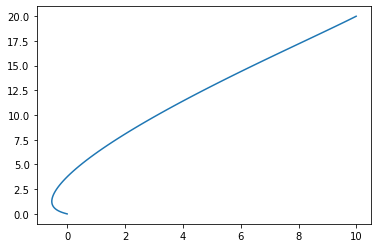

[151] loss: 0.000


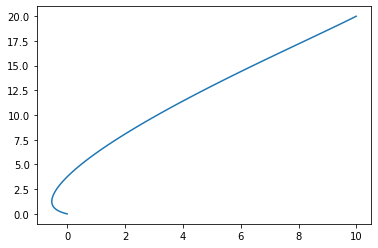

[152] loss: 0.000


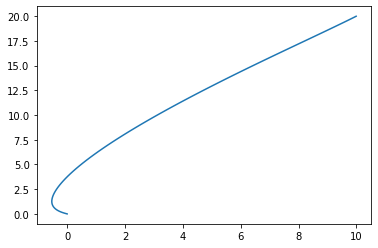

[153] loss: 0.000


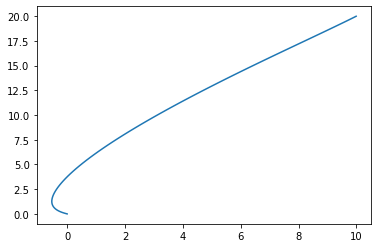

[154] loss: 0.000


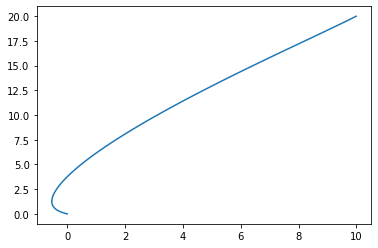

[155] loss: 0.000


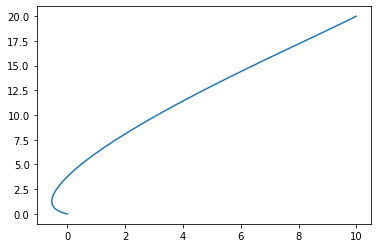

[156] loss: 0.000


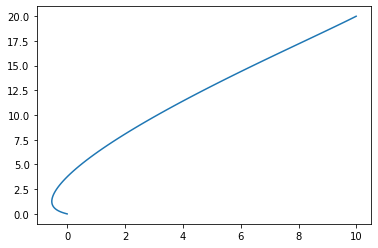

[157] loss: 0.000


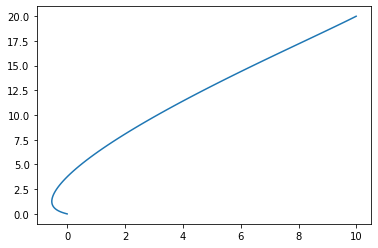

[158] loss: 0.000


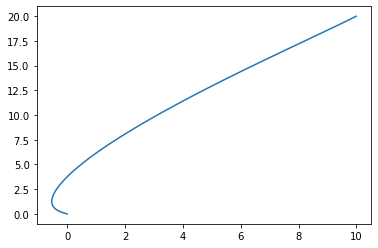

[159] loss: 0.000


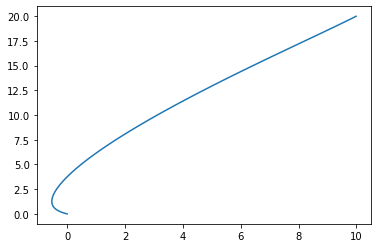

[160] loss: 0.000


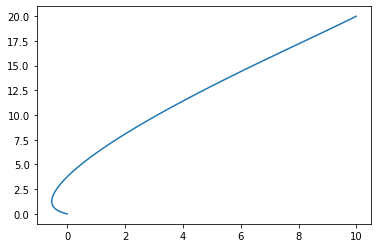

[161] loss: 0.000


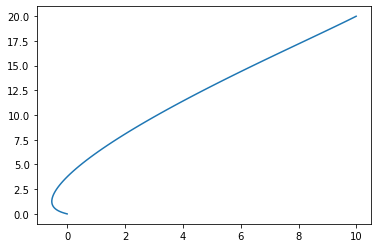

[162] loss: 0.000


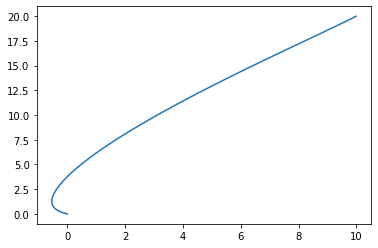

[163] loss: 0.000


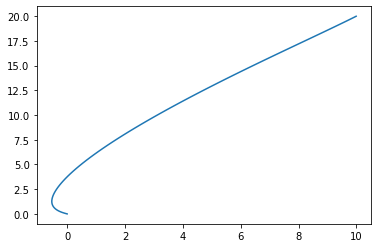

[164] loss: 0.000


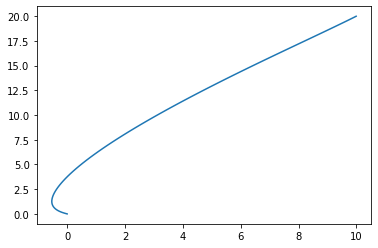

[165] loss: 0.000


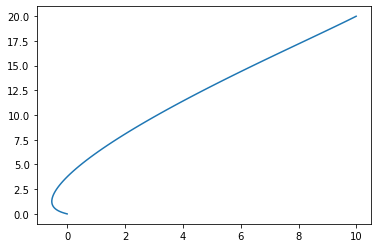

[166] loss: 0.000


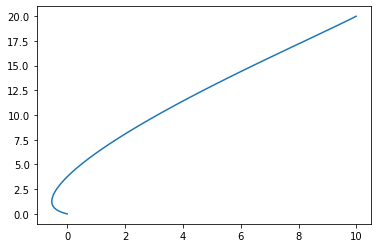

[167] loss: 0.000


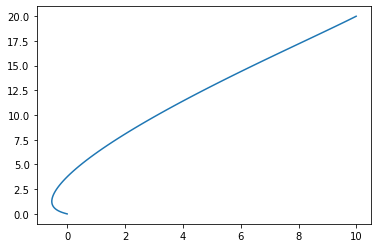

[168] loss: 0.000


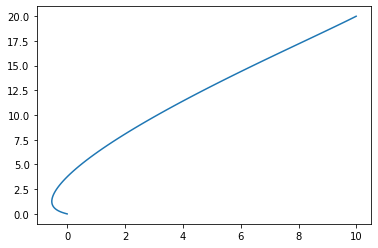

[169] loss: 0.000


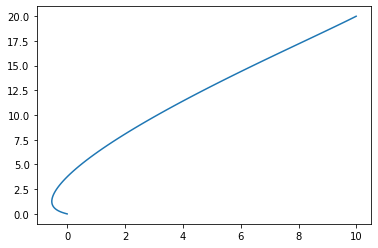

[170] loss: 0.000


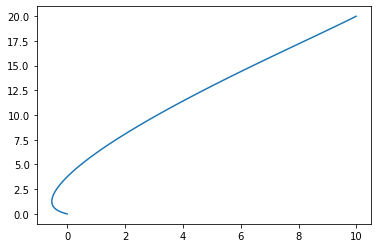

[171] loss: 0.000


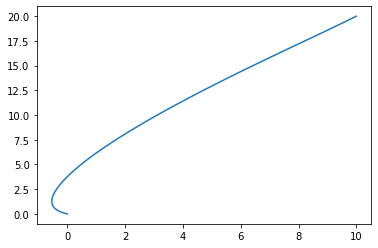

[172] loss: 0.000


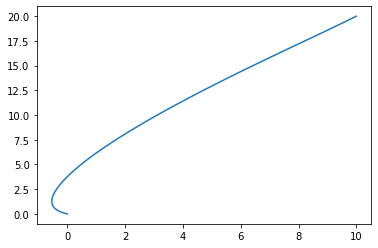

[173] loss: 0.000


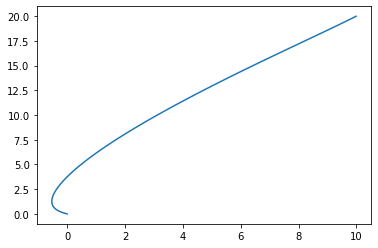

[174] loss: 0.000


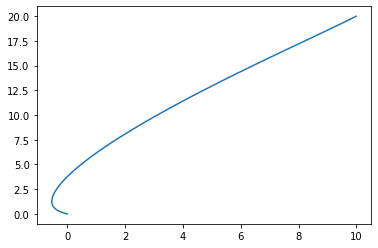

[175] loss: 0.000


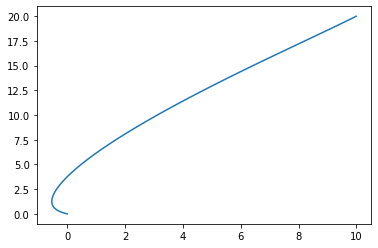

[176] loss: 0.000


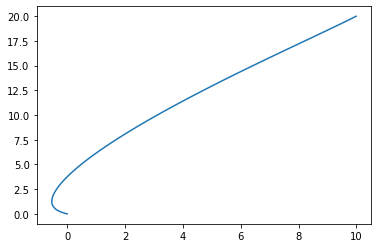

[177] loss: 0.000


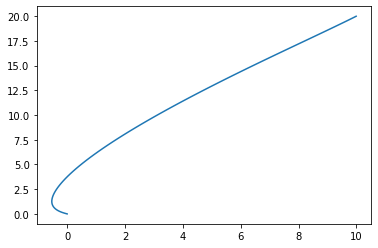

[178] loss: 0.000


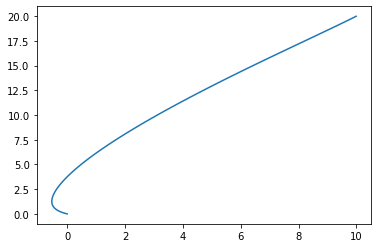

[179] loss: 0.000


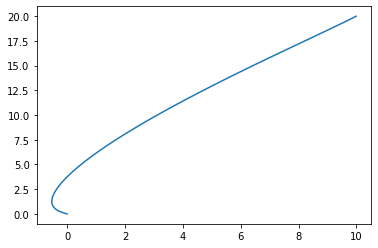

[180] loss: 0.000


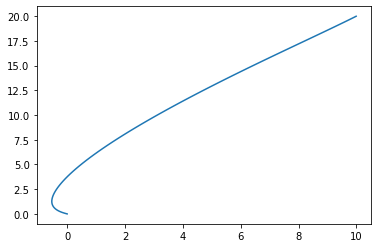

[181] loss: 0.000


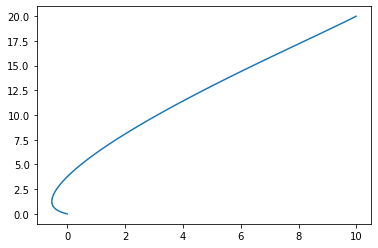

[182] loss: 0.000


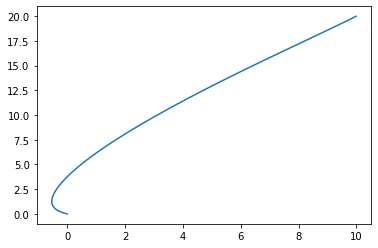

[183] loss: 0.000


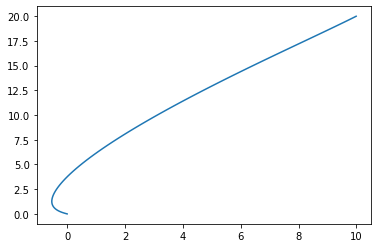

[184] loss: 0.000


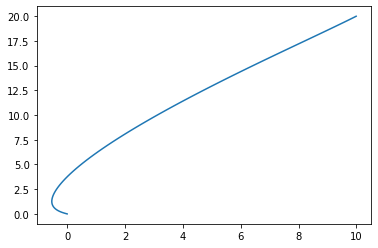

[185] loss: 0.000


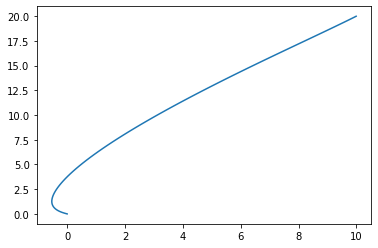

[186] loss: 0.000


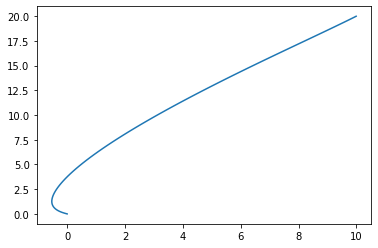

[187] loss: 0.000


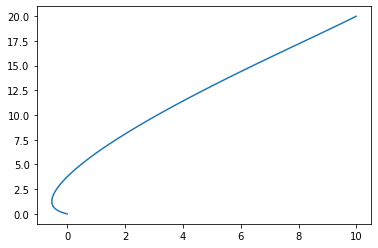

[188] loss: 0.000


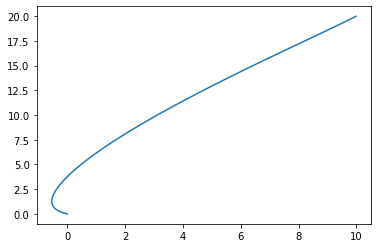

[189] loss: 0.000


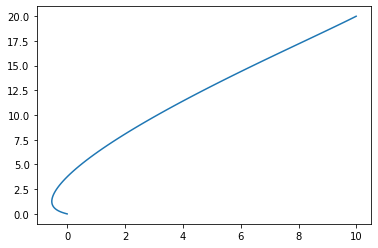

[190] loss: 0.000


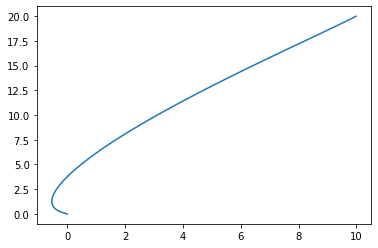

[191] loss: 0.000


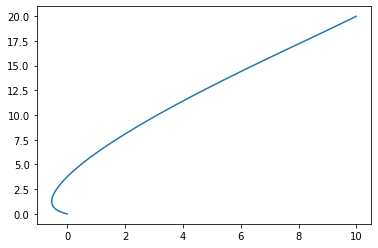

[192] loss: 0.000


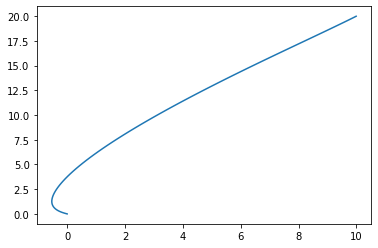

[193] loss: 0.000


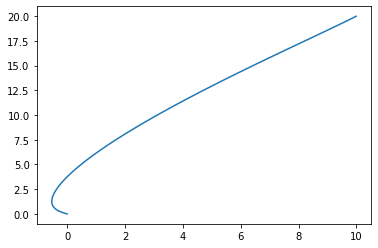

[194] loss: 0.000


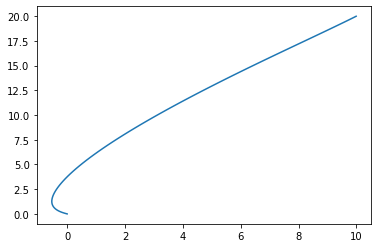

[195] loss: 0.000


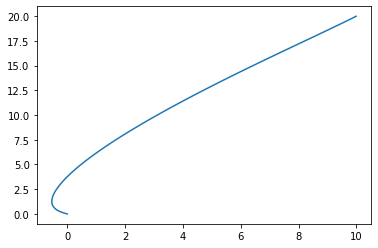

[196] loss: 0.000


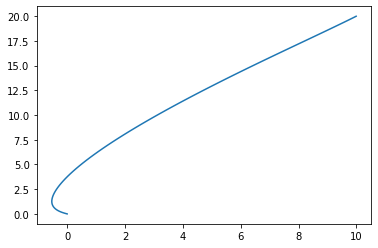

[197] loss: 0.000


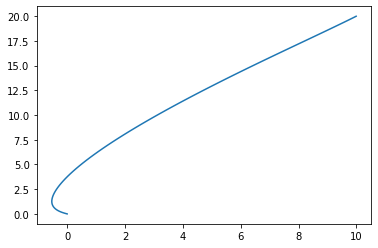

[198] loss: 0.000


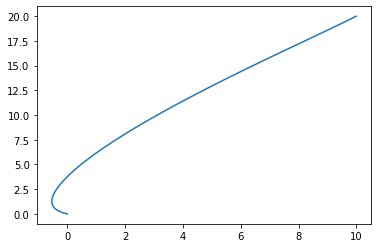

[199] loss: 0.000


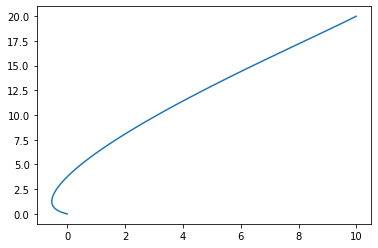

[200] loss: 0.000


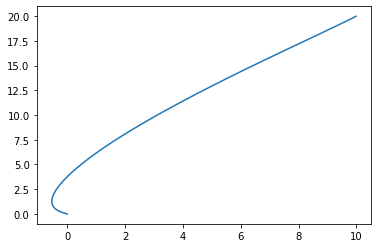

In [96]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(200)  # solve the optimization problem

## 4. Analysis